# Into the Keras Rabbit Hole

<a href="https://colab.research.google.com/github/luckykadam/adder/blob/master/full_adder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
</a>
<a href="https://github.com/luckykadam/adder/blob/master/full_adder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub
</a>

## Introduction

Have you ever finished reading an article on ML using Keras and felt: OK, but why didn't it talk about the concepts I studied in University? Is the abstraction provided by Keras too much for you?

* If not, then you must already be an ML expert (or a genius) and this article is not for you.

* If yes, then you are at the right place!

In this notebook, we will try to emulate Binary Full Adder using Keras. We are going to:

1. define the minimal neural network to achieve this
2. analyse every parameter learnt
3. identify the logic learnt by each neuron
4. draw the circuit learnt
5. embrace the "thinking process" of ML

## Background

I always felt uncomfortable following Machine Learning tutorials. It looked like magic to me. My smallest tweak would break the code apart. In the meanwhile, I did come across some great articles, which really helped me put together the pieces of "the puzzle".

While I explored more, I observed that, it is more beneficial for a new-comer to analyse the individual parameters, and how they contribute to the final output, instead of starting with complex task like cat/dog image classification, which might be overwhelming.

Here, I share an experiment in which we analyse deeply a rather simple neural network.

## Neurons

A single neuron is only capable of learning a linear decision boundary, but when sufficient units and layers of neurons work together, they can learn theoretically any complex function. This property of NNs has been mathematically proven, and demonstrated via many examples.

<a href="https://pdfs.semanticscholar.org/05ce/b32839c26c8d2cb38d5529cf7720a68c3fab.pdf">The proof</a> to this theorem is out of scope of this article, but we will put it to test and verify the results.

## Binary Adder

Binary Adder is a circuit to add two binary numbers.

### Half Adder

The Half Adder is used to add two binary bits. The half adder outputs the sum of two input bits and a carry value.

<img height="120" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Half_Adder.svg/360px-Half_Adder.svg.png">

### Full Adder

A Full Adder can perform an addition operation on three bits. The full adder produces a sum of three inputs and carry value. The carry value can then be used as input to the next full adder.

Using this unit in repeatition, two binary numbers of arbitrary length can be added.

<img height="220" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Full-adder_logic_diagram.svg/800px-Full-adder_logic_diagram.svg.png">

Boolean Expressions:

C<sub>out</sub> = ((A xor B) and C) or (A and B)

S = (A xor B) xor C<sub>in</sub>

Simplifying them in SOP (sum of products form):

C<sub>out</sub> = AB + AC + BC

S = ABC + (AB + AC + BC)'



## Logic Gates

Some logic gates which have a linear decision boundary(eg. AND, OR, NAND, NOR) can be represented using a single neuron, whereas some logic gates don't have a linear decision boundary(eg. XOR) and require multiple neurons or layers. A detailed explaination can be found <a href="https://medium.com/@stanleydukor/neural-representation-of-and-or-not-xor-and-xnor-logic-gates-perceptron-algorithm-b0275375fea1">here</a>.

Decision boundaries for AND and OR gates:

<br/>
<img height="200" src="img/and_gate.png">
<img height="200" src="img/or_gate.png">

Decision boundaries for XOR gate:

<br/>
<img height="200" src="img/xor_gate.png">

## Implementation

We are going to use Keras (`tf.keras` from Tensorflow 2.0) to create a neural network that can simulate full adder. Why are we involving `tensorflow` here? Because in future Keras will have no existense outside Tensorflow. As per Keras documentation

```
The 2.3.0 release will be the last major release of multi-backend Keras. Multi-backend Keras is superseded by tf.keras.
```

In [1]:
# only for Google Colab compatibiity
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import models, layers, activations

print(tf.__version__)
np.random.seed(0)
tf.random.set_seed(0)

2.0.0


## Dataset creation

There are only 8 possible combination of inputs and ouputs. To create the dataset, we are going to repeat these unique samples.

In [3]:
n_samples = 100000//8

In [4]:
x_samples = [[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]]
y_samples = [[0, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 1]]
x = np.array(x_samples * n_samples) # a, b, c
y = np.array(y_samples * n_samples) # c, s

sk-learn provides great functionality to split the dataset into train and test samples.

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True)

## Model

We model the problem as classification of sum bit as active/inactive and carry bit as active/inactive.

Keras provides multiple ways to define a model.

1. `Sequential` API provides an easy interface to create a model, where data flows sequentially through a stack of layers.
2. `Model` Functional API can define complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.
3. To get even more control, Keras allows to extend `Model` class and override `__init__` and `call` functions.

In our example we don't want any feedback loop, hence `Sequential` model would work. The layers in our network are:

1. `Input`: Inputs to the network are 3 bits: a, b and c (carry).
2. `Dense`: Hidden layer with 3 neurons. The number of neurons is arrived at experimentally.
3. `Dense`: Outputs are 2 bits: c (next carry), s (sum).

In [6]:
model = models.Sequential(name='full_adder')
model.add(layers.Input(shape=(3,), name='input'))
model.add(layers.Dense(units=3, activation=activations.sigmoid, name='hidden'))
model.add(layers.Dense(units=2, activation=activations.sigmoid, name='output'))

model.summary()

Model: "full_adder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 3)                 12        
_________________________________________________________________
output (Dense)               (None, 2)                 8         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


## Loss function

Choice of loss function is a crucial step. The most common choices for different types of problems are:

1. **Regression**: Default choice is `mean_squared_error`.
2. **Classification**:
  * **Binary Classification**: Default choice is `binary_crossentropy`. The function requires that the output layer is configured with a `sigmoid` activation to limit output to (0, 1).
  * **Multi-Class Single-Label Classification**: When a sample can belong to any one class (of >2 options), default choice is `categorical_crossentropy`. This also requires a `sigmoid` activated output layer.
  * **Multi-Class Multi-Label Classification**: When a sample might belong to multiple classes (of >1 options), default choice is `binary_crossentropy`. Here each classification is considered independent of each other, and effectively multiple binary classifiers are learned at once. This also requires a `sigmoid` activated output layer.

In our Full Adder model both the outputs can be '1' at the same time, hence it would be a multi-class multi-label classification.

On choosing optimizer, `adam` works well in most cases.

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training

When training set is large, each iteration (parameter update step) might take very long. This way progress in parameters is very slow.

One trick to fasten this process is to consider small subset of train set, that fairly represents the complete train set, for each iteration. That way iterations would complete in short durations, and parameters would be updated more frequently.

How would we create those small subset? Simplest way is to shuffle the train set and select subsets sequentially.

This trick is called **Mini-Batching**. In keras default method is mini batching, controlled by `batch_size` parameter of `Model.fit()` method. To disable mini-batching, set `batch_size` parameter equal to the size of train set.


In [8]:
model.fit(x_train, y_train, batch_size=16, epochs=10)
score = model.evaluate(x_test, y_test, verbose=2)

Train on 90000 samples
Epoch 1/10
90000/90000 [==============================] - 7s 82us/sample - loss: 0.5135 - accuracy: 0.7236
Epoch 2/10
90000/90000 [==============================] - 6s 67us/sample - loss: 0.3258 - accuracy: 0.8754
Epoch 3/10
90000/90000 [==============================] - 6s 70us/sample - loss: 0.2655 - accuracy: 0.8927
Epoch 4/10
90000/90000 [==============================] - 6s 71us/sample - loss: 0.1882 - accuracy: 0.9378
Epoch 5/10
90000/90000 [==============================] - 7s 73us/sample - loss: 0.1537 - accuracy: 0.9378
Epoch 6/10
90000/90000 [==============================] - 6s 72us/sample - loss: 0.1429 - accuracy: 0.9378
Epoch 7/10
90000/90000 [==============================] - 6s 69us/sample - loss: 0.1248 - accuracy: 0.9378
Epoch 8/10
90000/90000 [==============================] - 6s 69us/sample - loss: 0.0605 - accuracy: 0.9940
Epoch 9/10
90000/90000 [==============================] - 6s 66us/sample - loss: 0.0277 - accuracy: 1.0000
Epoch 10/10
90

## Testing

Let's write some code to add two numbers of arbitraty length.

Generate two random numbers in range (0, 2<sup>max_bits-1</sup>), so that their sum is in the range (0, 2<sup>max_bits</sup>)

In [9]:
max_bits = 8

a = np.random.randint(np.power(2, max_bits-1))
b = np.random.randint(np.power(2, max_bits-1))

a_bin = 1 * (np.flip(list(np.binary_repr(a, width=max_bits)), axis=-1) == '1')
b_bin = 1 * (np.flip(list(np.binary_repr(b, width=max_bits)), axis=-1) == '1')

print('a: {}, b: {}'.format(a, b))
print('binary representations -> a: {}, b: {}'.format(a_bin, b_bin))

a: 18, b: 39
binary representations -> a: [0 1 0 0 1 0 0 0], b: [1 1 1 0 0 1 0 0]


Now, iterate over bits of both numbers, feeding them, with carry bit, to the model. The ouput at each step is used to evaluate the corresponding bit of summed value, and update the carry bit.

In [10]:
c = 0
predictions = np.zeros(max_bits)

for i in range(max_bits):
    a_b_c = np.array([[a_bin[i], b_bin[i], c]], dtype='float32')
    c_s = model(a_b_c)[0]
    c = c_s[0]
    predictions[i] = c_s[1]

summed_bin = 1 * (predictions > 0.5)
summed = np.packbits(np.flip(summed_bin , axis=-1))[0]

print('predictions: {}'.format(predictions))
print('binary representations -> summed: {}'.format(summed_bin))
print('summed: {}'.format(summed))

predictions: [0.99423075 0.00917831 0.0092618  0.99443108 0.99431276 0.99423099
 0.01244388 0.01244363]
binary representations -> summed: [1 0 0 1 1 1 0 0]
summed: 57


## Analysis

As we can see, our model works perfectly. 

But, what has each neuron learnt? Let's analyse the weights, biases and decision boundary of each neuron.

In [11]:
hidden_layer = model.get_layer('hidden')
[hidden_weights, hidden_biases] = hidden_layer.weights

output_layer = model.get_layer('output')
[output_weights, output_biases] = output_layer.weights

### Decision Surface

Decision surface is a hypersurface that partitions the underlying vector space into two sets, one for each class. For 2-dimensional input, it reduces to a 2D curve, and is often called Decision Boundary.

Here, input is 3-dimensional, hence we get a 3D surface as decision surface.

For an individual neuron, this 3D surface, is actually a 3D plane. We are going to draw and analyse these Decision planes for each neuron.

We will be using `matplotlib` library for plotting graphs.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [13]:
def get_neuron_decision_plane(weight, bias):
    a = weight[0]
    b = weight[1]
    c = weight[2]
    d = bias
    def z_function(x, y):
        return -a*x/c + -b*y/c + -d/c

    x = np.linspace(-1, 1, 3)
    y = np.linspace(-1, 1, 3)
    X, Y = np.meshgrid(x, y)
    Z = z_function(X, Y)
    length = 1 / np.sqrt(a*a + b*b + c*c)
    normal = ((0, a * length), (0, b * length), (z_function(0, 0), z_function(0, 0) + (c * length)))
    return X, Y, Z, normal

In [14]:
def plot_decision_planes(weights, biases, labels, title):
    n = len(weights)
    fig = plt.figure(figsize=plt.figaspect(1/n))
    fig.suptitle(title, fontsize=16, y=-0.01)
    for i in range(n):
        X, Y, Z, normal = get_neuron_decision_plane(weights[i], biases[i])
        ax = fig.add_subplot(1, n, i+1, projection='3d')
        ax.plot_surface(X, Y, Z, color='green', alpha=0.5)
        ax.plot(*normal, color='red')
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel(labels[2])
    plt.show()

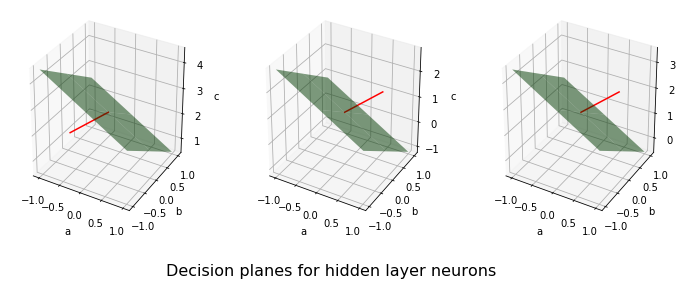

In [15]:
plot_decision_planes(tf.transpose(hidden_weights), hidden_biases, ['a', 'b', 'c'], "Decision planes for hidden layer neurons")

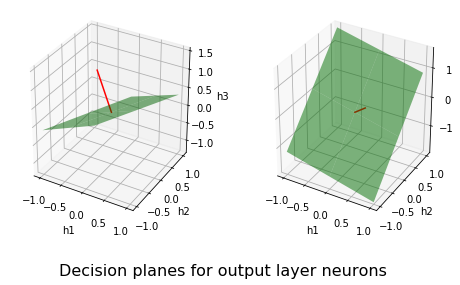

In [16]:
plot_decision_planes(tf.transpose(output_weights), output_biases, ['h1', 'h2', 'h3'], "Decision planes for output layer neurons")

In the above diagrams, the decision plane divides the space into two halves: positive and negative. The red normal depicts the positive space, i.e. the inputs lying in the that half will output 1 (positive).

## Truth tables

The plots are visually pleasing but, to make sense out of them is quite a challenge. Let's take an easier approach to help us come up with boolean expression of each neuron: Truth table.

In [17]:
truth_table_input = np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]])

hidden_truth_table = hidden_layer(truth_table_input) > 0.5
output_truth_table = output_layer(truth_table_input) > 0.5

print(truth_table_input)
print(hidden_truth_table.numpy())
print(output_truth_table.numpy())

[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
[[ True False False]
 [ True  True False]
 [ True  True False]
 [ True  True  True]
 [ True  True False]
 [ True  True  True]
 [ True  True  True]
 [False  True  True]]
[[False False]
 [ True False]
 [ True  True]
 [ True  True]
 [False False]
 [ True False]
 [False  True]
 [ True False]]


## Boolean Expressions

From the truth table, we can easily solve for boolean expression.

Hidden layers:


h<sub>1</sub> = A' + B' + C'

h<sub>2</sub> = A + B + C

h<sub>3</sub> = AB + AC + BC

Output layers:

o<sub>1</sub> = h<sub>1</sub>'h<sub>2</sub> + h<sub>3</sub>

o<sub>2</sub> = h<sub>1</sub>'h<sub>3</sub>' + h<sub>1</sub>'h<sub>2</sub> + h<sub>2</sub>h<sub>3</sub>'


### Final expressions

Eliminating h<sub>i</sub> and simplifying, we get the final expression:

C<sub>out</sub> = o<sub>1</sub> = AB + AC + BC

S = o<sub>2</sub> = ABC + (AB + AC + BC)'

These are indeed the equations for Full Adder.



## Learnt Circuit

From the equations, we can draw the circuit (not unique in any way).

<img height="400" src="img/full_adder_learnt_circuit.png">

Looks too complicated?

Yeah, maybe. But, this is it. For the given restrictions, this is what ML came up with.

## Conclusion

After a little effort, we finally have the learnt circuit of Binary Full Adder. Though, the way it broke down the equations into intemediate variables (hidden layer) might not be very intuitive for most humans, it still learns the objective. And this argument holds for most ML applications: the hidden layer might not always make sense to human observation, yet it makes its important contribution to the final output. It would be weird to say, but we must respect the way ML "thinks".

Food for thought: A similar behavior is observed in non-human species. At first glance their actions might not look rational, but still they achieve the same objective as human: "survive", and sometime more effeciently. This uncertain behavior, with a pretty much certain objective, is what characterizes living beings. So, exactly how alive are these ML models? This is a topic for another day. 

## Further Reading

You might be wondering, the way we added two numbers, resembles a lot with how recurrent neural networks work. In fact, we will be developing an RNN for the same task in the next experiment.

Another experiment for half adder can be found at: <https://github.com/luckykadam/adder/blob/master/half_adder.ipynb>

## References:

1. <https://en.wikibooks.org/wiki/Digital_Electronics/Digital_Adder>
2. <https://www.cs.bham.ac.uk/~pxt/NC/l4_JB.pdf>
3. <https://medium.com/@stanleydukor/neural-representation-of-and-or-not-xor-and-xnor-logic-gates-perceptron-algorithm-b0275375fea1>
4. <https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/>